# Local Hartree Calculations in Rhombohedral

## Presets

In [82]:
using Optics_in_the_length_gauge
using PhysicalConstants, LinearAlgebra
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
const kB = (PhysicalConstants.CODATA2018.k_B |> u"eV/K").val
# add https://github.com/fernandopenaranda/Optics_in_the_length_gauge
# units meV, fs, K

proj_folder = dirname(pwd())
rhomb_folder = proj_folder * "/model/rhombohedral/"
common_folder = proj_folder * "/comfunctions/"
figures_folder = proj_folder * "/Paper/Figures/"

include(rhomb_folder * "model.jl")
include(rhomb_folder * "observables.jl")
include(rhomb_folder * "plotters.jl")
include(rhomb_folder * "filling.jl")
include(rhomb_folder * "wrapper_lmc.jl")
include(rhomb_folder * "spontaneous_sym_breakingmodels.jl")
include(rhomb_folder * "local_hartree_optimization.jl")
include(common_folder * "separate_contributions.jl")

plotmap! (generic function with 1 method)

In [57]:
μlist = collect(0:0.1:9)
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 0*44, 2, 0)
T = 2
B = 10
evals = 10000
N = 7
T = 2 #evals 80000 not perfect
τ = 200

200

In [4]:
lmc_presets(N, μ,ξ, p::Params_rhombohedral; kws...) =  xxx_lmc_presets(N, μ, ξ, p; kws...)
lmcnoshift_presets(μ,ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, berry_contribution = true, omm_contribution = true, fermi_surface = false, with_shift = false)
lmcshift_presets(μ,ξ) = xxx_lmc_presets(N, μ, ξ, p; evals = evals, T = T, fermi_surface = false, with_shift = true)

sigmaijkpresets = lmc_presets(5, 0,1, p);

## Calculations

In [48]:
estimated_bound_width = 20
evals = 1e5
η = 0.05
# compute the interpolated functions passed to the optimization
ϵ_range, int_dos = interpolated_dos(sigmaijkpresets, 2estimated_bound_width, evals = evals, η = η)
n = interpolated_n(int_dos, ϵ_range);

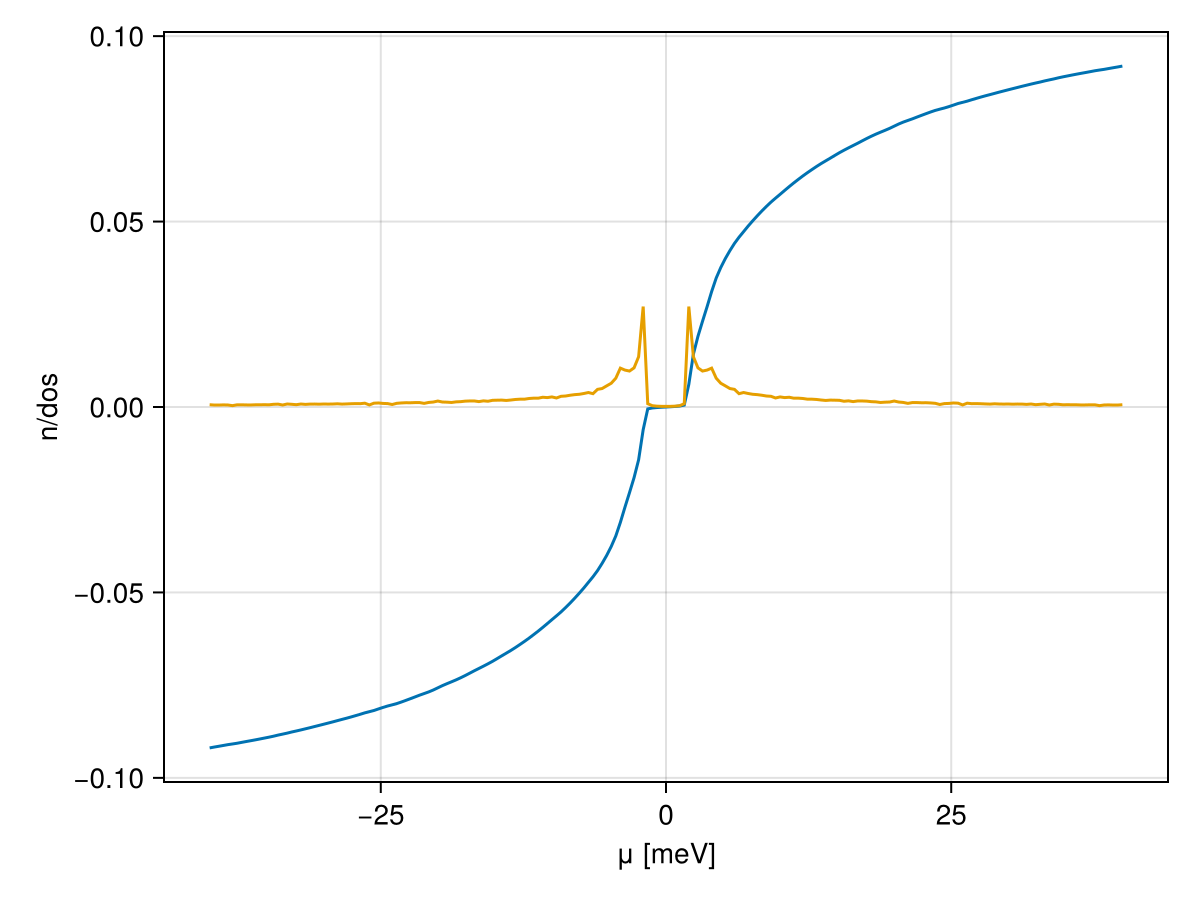

In [49]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n/dos")
lines!(ax, ϵ_range, n.(ϵ_range))
lines!(ax, ϵ_range, int_dos.(ϵ_range))
fig

In [52]:
# μ = 4.0
# @time μαs = Emin_μαs(int_dos, n, μ; random_guesses = 40,
#     U = 10, J = 10, λ = 1e3, evals = 5e2, η = 0.05, 
#     estimated_bound_width = 10, iterations = 200, int_model = :SU2) 
# println(μαs)

E: -0.08550391432405396
constraint: ∑n_α - 4n0 = -0.055477732812387395
minimal μαs: [-1.729538075726433, 4.690564942077816, 4.690564942068253, -1.7295380757136924]
  0.428576 seconds (9.77 M allocations: 632.378 MiB, 15.91% gc time)
[-1.729538075726433, 4.690564942077816, 4.690564942068253, -1.7295380757136924]


In [81]:
U = 20
J = -10

@time nαs = Emin_nαs(int_dos, n, μlist; random_guesses = 40,
    U = U, J = J, λ = 1e3, evals = 5e2, η = 0.05, 
    estimated_bound_width = 20, iterations = 200, int_model = :SU2);


 22.121975 seconds (491.97 M allocations: 31.107 GiB, 13.33% gc time)


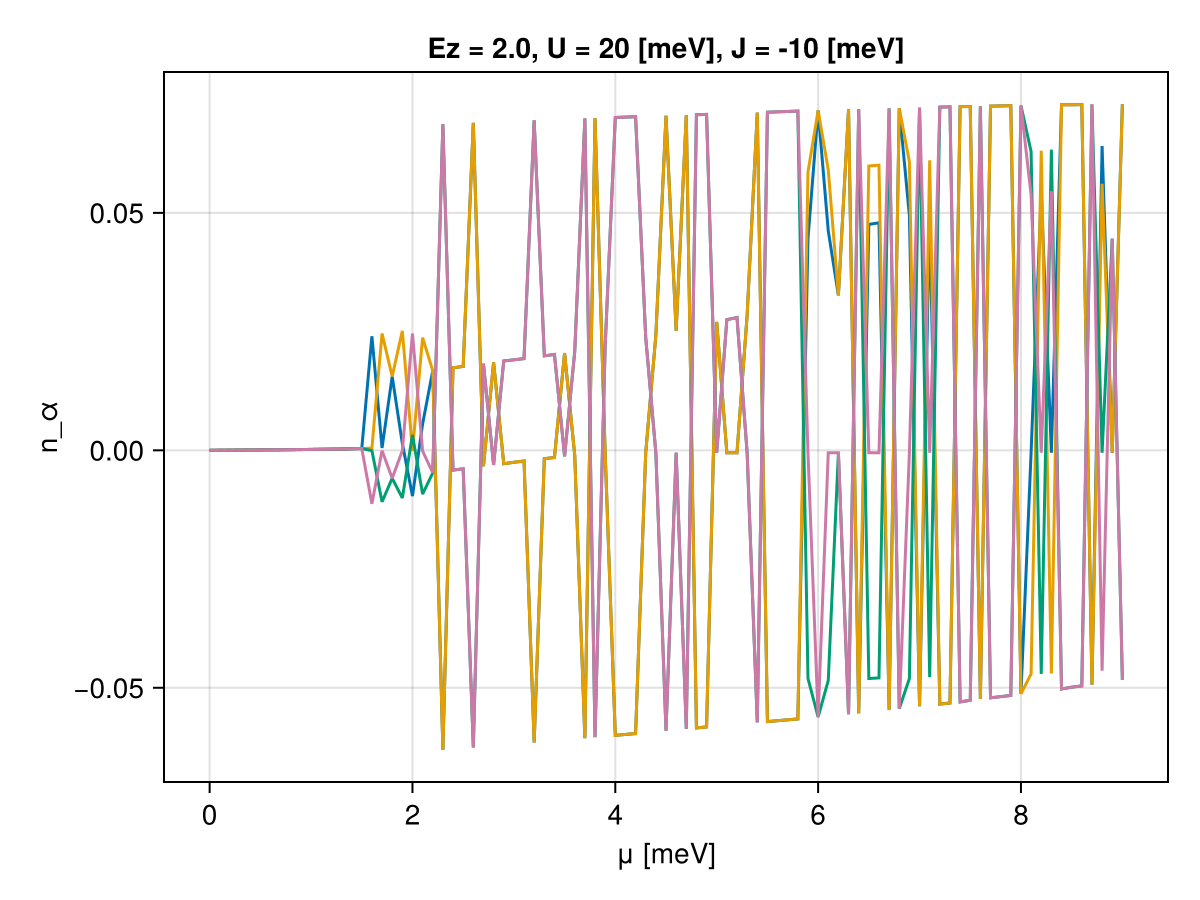

In [83]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n_α", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [nαs[i][1] for i in 1:length(nαs)], label = "K↑")
lines!(ax, μlist, [nαs[i][2] for i in 1:length(nαs)], label = "K'↑")
lines!(ax, μlist,[nαs[i][3] for i in 1:length(nαs)], label = "K↓")
lines!(ax, μlist, [nαs[i][4] for i in 1:length(nαs)], label = "K'↓")
fig

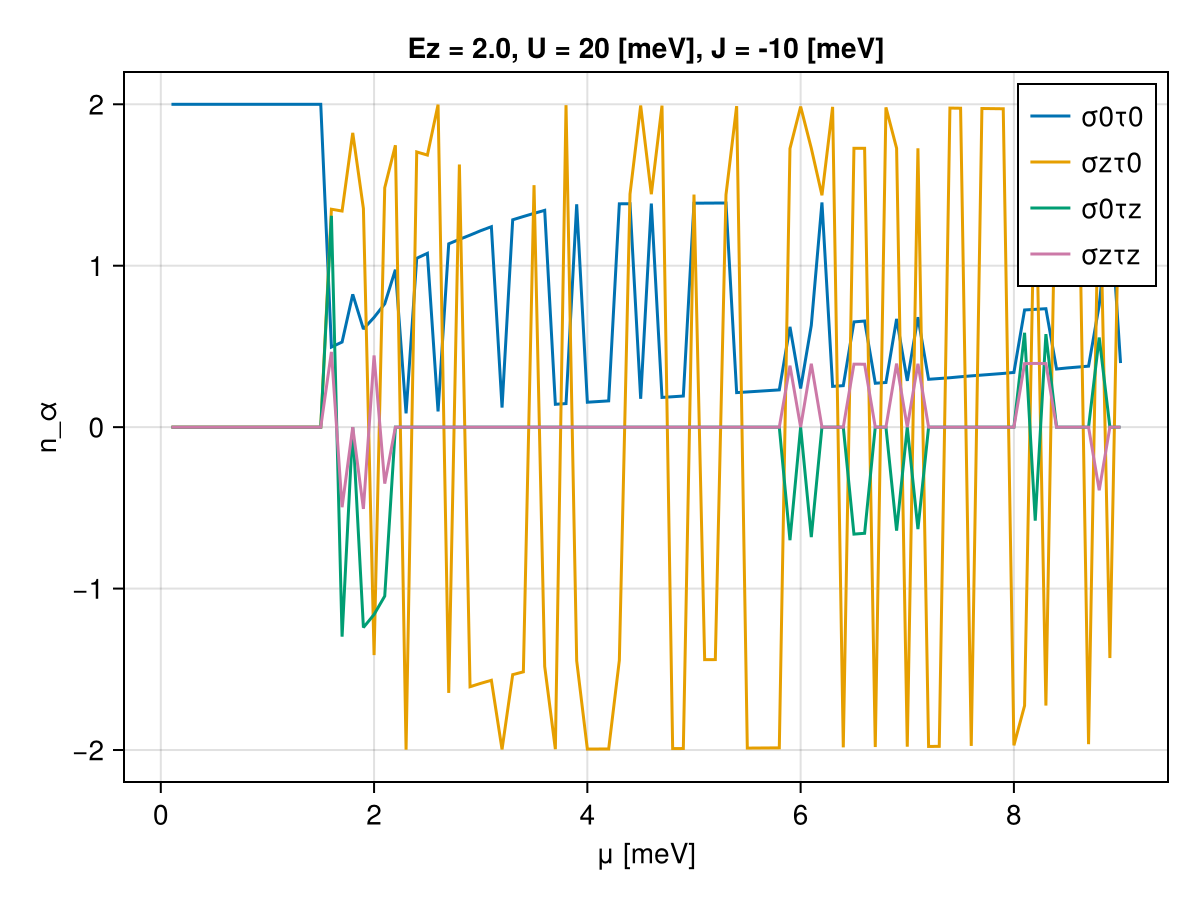

In [85]:
fig = Figure(); ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "n_α", title = "Ez = $(p.Delta_Ez), U = $(U) [meV], J = $(J) [meV]")
lines!(ax, μlist, [rh_order_parameter(nαs[i])[1] for i in 1:length(nαs)], label = "σ0τ0")
lines!(ax, μlist, [rh_order_parameter(nαs[i])[2] for i in 1:length(nαs)], label = "σzτ0")
lines!(ax, μlist,[rh_order_parameter(nαs[i])[3] for i in 1:length(nαs)], label = "σ0τz")
lines!(ax, μlist, [rh_order_parameter(nαs[i])[4] for i in 1:length(nαs)], label = "σzτz")
axislegend(ax)
fig

### Bands of the spinfull model with local Hartree

In [107]:
function spinfull_plotbands(N, p, μαs; points = 100)
    fig = Figure()
    ax = Axis(fig[1:2, 0]; xlabel = "kx", ylabel = "E [meV]")
    spinfull_plotbands!(ax, N, p, μαs, points = points)
    return fig
end
"""
Now 1 → K↑, 2 → K'↑, 3 → K↓, 4 → K'↓.
"""
function spinfull_plotbands!(ax, N, p, μαs; points = 100)
    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = p.Delta_Ez, Valley_asym = 0)]

    abcNplotbandsk(ax, N, points, ps[1]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[2]; ylims = [-1, 1])#, style = :dash)
    abcNplotbandsk(ax, N, points, ps[3]; ylims = [-1, 1])#, style = :solid)
    abcNplotbandsk(ax, N, points, ps[4]; ylims = [-1, 1])#, style = :dash)
end

function spinfull_dos(N, p, μαs, μlist; evals = 100, η = 0.05)
    ps =[Params_rhombohedral(p, μ = μαs[1], ξ = 1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[2], ξ = -1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[3], ξ = 1, Delta_Ez = p.Delta_Ez, Valley_asym = 0),
        Params_rhombohedral(p, μ = μαs[4], ξ = -1, Delta_Ez = p.Delta_Ez, Valley_asym = 0)]

    ω, js = spinfull_dos(N, ps, η, evals)
    fig = Figure()
    ax = Axis(fig[1,1], xlabel = "μ [meV]", ylabel = "DOS (a.u.)")
    plot_dos!(ax, ω, js)
    fig
end

function spinfull_dos(N, ps, η, evals)
    nps = [xxx_lmc_presets(N, ps[i]) for i in 1:length(ps)]
    ω, j1 = c_dos(nps[1], μlist, η = η, evals = evals)
    ω, j2 = c_dos(nps[2], μlist, η = η, evals = evals)
    ω, j3 = c_dos(nps[3], μlist, η = η, evals = evals)
    ω, j4 = c_dos(nps[4], μlist, η = η, evals = evals)
    return ω, [j1,j2,j3,j4]
end

function plot_dos!(ax, ω, js)
    colors = [:black, :black, :gray, :gray]
    styles = [:solid, :dash, :solid, :dash]
    labels = ["K↑", "K'↑", "K↓","K'↓"]
    for (i,j) in enumerate(js)
        lines!(ax, ω, j, color = colors[i], linestyle = styles[i], label = labels[i])
    end
    axislegend(ax)
end

plot_dos! (generic function with 1 method)

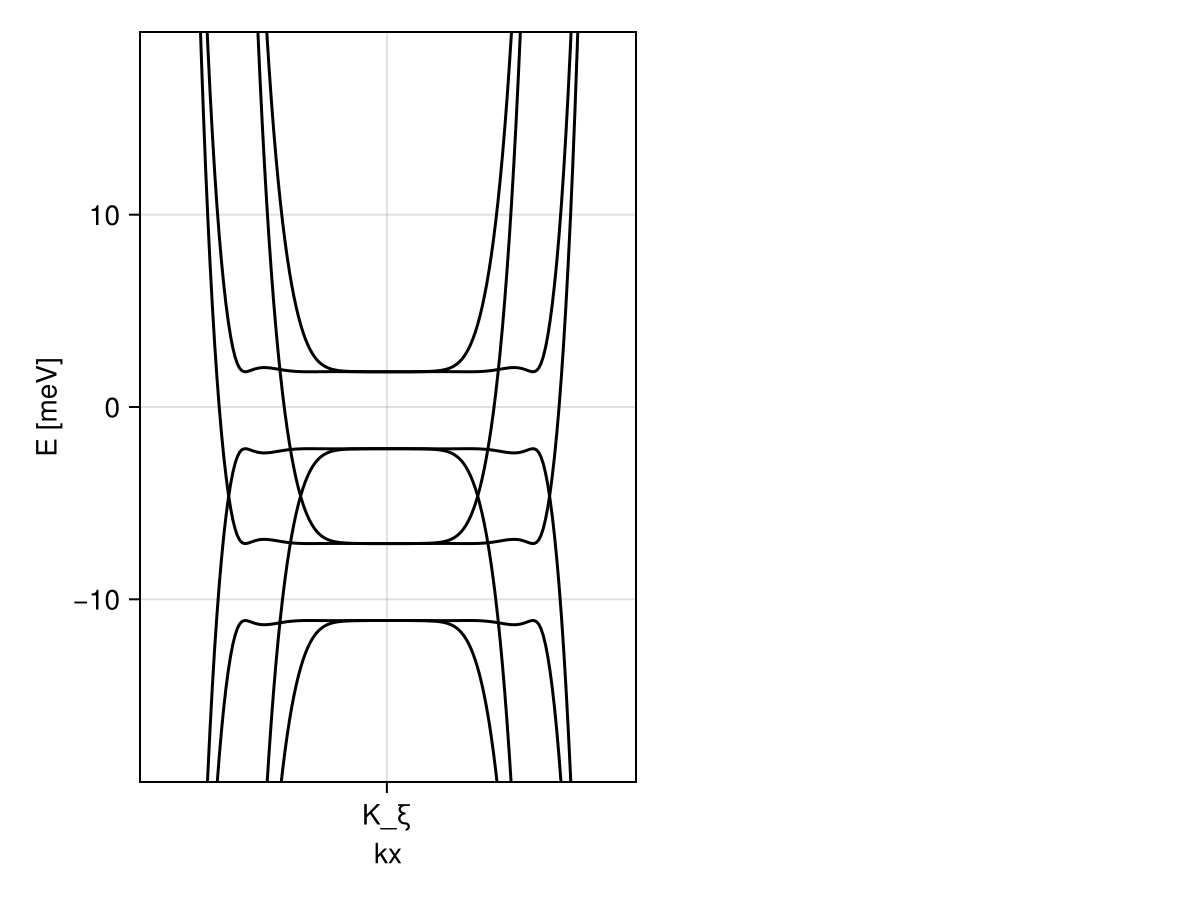

In [102]:
ind = 89
spinfull_plotbands(N, p, μαs[ind]; points = 100)

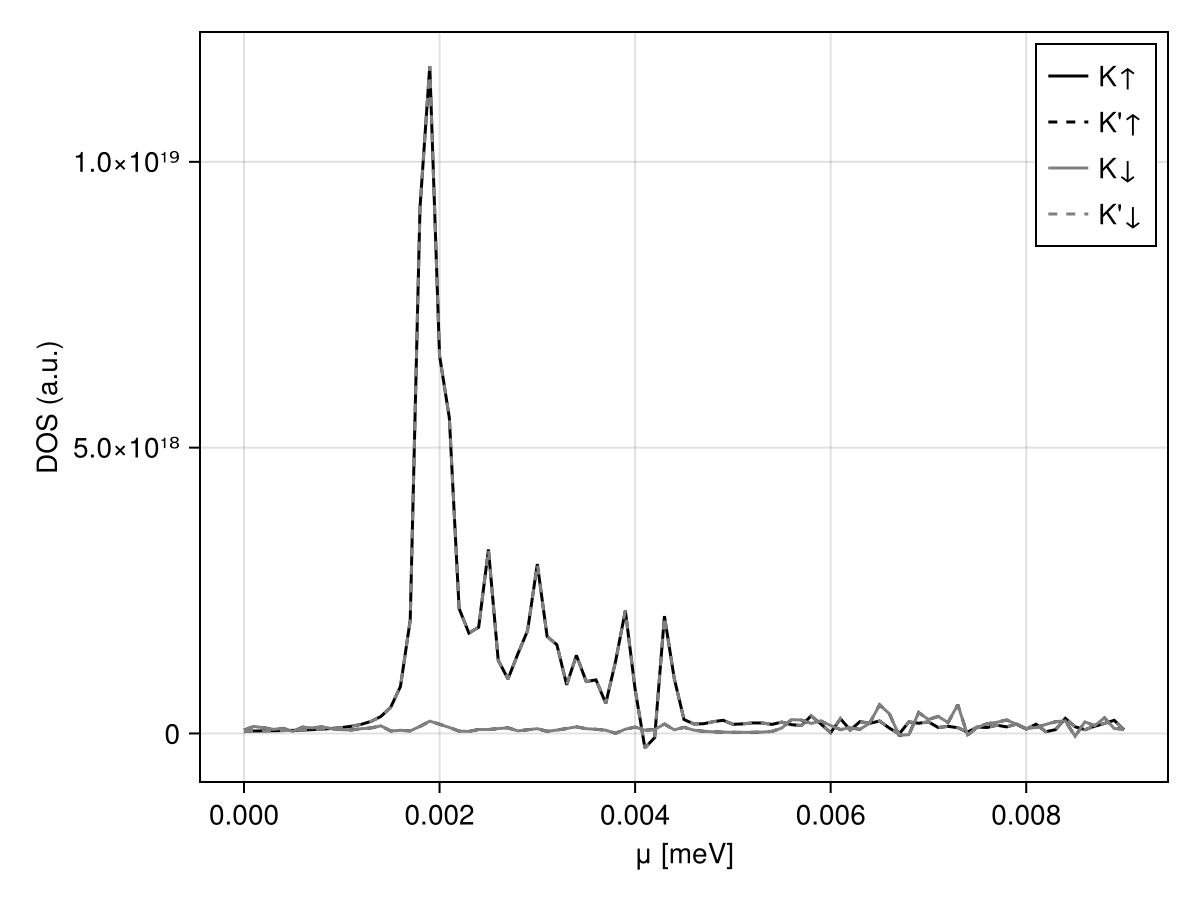

In [108]:
spinfull_dos(N, p, μαs[ind], μlist; evals = 1e3, η = 0.05)

### Compact expression single \mu  

In [41]:
include(rhomb_folder * "local_hartree_optimization.jl")
μ = 4.0
@time μαs = Emin_μαs(sigmaijkpresets, μ; random_guesses = 40,
    U = 20, J = -10, λ = 1e3, evals = 5e2, η = 0.05, 
    estimated_bound_width = 10, iterations = 200, int_model = :SU2) 
println(μαs)

guess number: 0 E: -0.037832331607802756
guess number: 1 E: -0.029680121691519065
guess number: 2 E: -0.02994567298249858
guess number: 3 E: -0.037832331627240944
guess number: 4 E: -0.029656549803892204
guess number: 5 E: -0.03783233162273602
guess number: 6 E: -0.02994567296355068
guess number: 7 E: -0.02965654980277014
guess number: 8 E: -0.037832331617011765
guess number: 9 E: -0.037832331624894945
guess number: 10 E: -0.024960638552398738
guess number: 11 E: -0.03783233161592205
guess number: 12 E: -0.03783233162350958
guess number: 13 E: -0.03783233162331305
guess number: 14 E: -0.037832331622012584
guess number: 15 E: -0.02994567298149255
guess number: 16 E: -0.037832331615217145
guess number: 17 E: -0.03783233162550788
guess number: 18 E: -0.024960638547548594
guess number: 19 E: -0.03783233161577676
guess number: 20 E: -0.03783233160923428
guess number: 21 E: -0.03783233161637481
guess number: 22 E: -0.03783233160768295
guess number: 23 E: -0.037832331614150005
guess number: 2